In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import os
import fnmatch
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from dask.diagnostics import ProgressBar
from IPython.display import clear_output
from src.project_configs import *
from src.plotting import *
from src.utils import *

In [3]:
pcs = load_gsam_pcs()
r = compute_r(pcs)
phase = compute_phase_number(compute_theta(pcs))
phase = phase.where((0.5<=r), 0)

In [4]:
initial_phase = phase.isel(time=slice(None, -2))
final_phase = phase.isel(time=slice(2, None))
assert(initial_phase.shape==final_phase.shape)

In [5]:
def get_var_moisture_sorted_files(var, lati, loni, timei):
    path=f'/glade/u/home/pangulo/work/gsam_dyamond_winter/northwest_tropical_pacific/{var}_moisture_space_grids_50pix'
    time_range = pd.date_range('2020-02-01', '2020-03-01', freq='3h')
    file_times = [time.strftime('%Y%m%d%H%M%S') for time in time_range[timei]]
    file_patterns = [path+f"/satfrac_sorted.lon_{int(lon)}.lat_{int(lat)}.northwest_tropical_pacific.DYAMOND2_9216x4608x74_10s_4608_{time}_*.nc" for lon, lat, time in zip(loni, lati, file_times)]
    files = []
    for i, f in enumerate(file_patterns):
        clear_output(wait=True)
        print(f'{100*i/len(file_patterns):.2f}%')
        found_files = glob(f)
        assert(len(found_files)==1)
        files.extend(found_files)
    return(files)

# Record file names in text files

In [6]:
var = 'W'
name = ['persisting', 'advancing', 'regressing']
for p in [4,5,6]:
    # ids will be tuple of arrays (timei, lati, loni)
    persisting_time_id, persisting_lat_id, persisting_lon_id = np.where((initial_phase.data == p) & (final_phase.data == p))
    regressing_time_id, regressing_lat_id, regressing_lon_id = np.where((initial_phase.data == p) & (final_phase.data == p - 1))
    advancing_time_id, advancing_lat_id, advancing_lon_id = np.where((initial_phase.data == p) & (final_phase.data == p + 1))
    print('-'*10)
    print(f"Phase {p}")
    print(f"Number of persisting files: {persisting_time_id.size}")
    print(f"Number of regressing files: {regressing_time_id.size}")
    print(f"Number of advancing files: {advancing_time_id.size}")
    print('-'*10)
    timei_list = [persisting_time_id, advancing_time_id, regressing_time_id]
    lati_list = [persisting_lat_id, advancing_lat_id, regressing_lat_id]
    loni_list = [persisting_lon_id, advancing_lon_id, regressing_lon_id]
    for n, timei, lati, loni in zip(name, timei_list, lati_list, loni_list):
        files = get_var_moisture_sorted_files(var, lati, loni, timei)
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'w') as f:
            for file in files:
                f.write(f"{file}\n")

99.17%


# Read files in and compute mean streamfunction

## Mean profiles

In [7]:
var = 'W'
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        clear_output(wait=True)
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]
        print(f'Found {len(files)} files')
        ds = xr.open_mfdataset(files, concat_dim='scene', combine='nested')
        w = ds.W
        w_mean = w.mean('clolumn')
        massflux = w_mean * ds.rho
        with ProgressBar():
            massflux.to_netcdf(f'{data_dir()}/phase{p}.{n}.mean_mass_flux.nc')

regressing Phase 6
Found 121 files
[########################################] | 100% Completed | 417.91 ms


## Circulation composite

In [8]:
var = 'W'
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        clear_output(wait=True)
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]
        print(f'Found {len(files)} files')
        ds = xr.open_mfdataset(files, concat_dim='scene', combine='nested')
        w = ds.W
        w_mean = w.mean('column')
        w_anom = w - w_mean
        circ = w_anom.sel(z=slice(None, 17e3)).cumsum('column')
        with ProgressBar():
            circ.mean('scene').to_netcdf(f'{data_dir()}/phase{p}.{n}.circulation.nc')

regressing Phase 6
Found 121 files
[########################################] | 100% Completed | 432.55 ms


## Minimum streamfunction

In [6]:
var = 'W'
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]
        print(f'Found {len(files)} files')
        ds = xr.open_mfdataset(files, concat_dim='scene', combine='nested')
        w = ds.W
        w_mean = w.mean('column')
        w_anom = w - w_mean
        circ = w_anom.sel(z=slice(None, 17e3)).cumsum('column')
        with ProgressBar():
            circ.min(('column', 'z')).to_netcdf(f'{data_dir()}/phase{p}.{n}.min_psi.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 4.29 sms
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 2.46 sms
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 1.54 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 2.66 sms
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 2.05 sms
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 1.96 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 1.85 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 932.39 ms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 425.23 ms


In [9]:
name = ['persisting']
for n in name:
    for p in [5]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]
        print(f'Found {len(files)} files')
        surf_ds = xr.open_mfdataset([_.replace('W', '2D').replace('_2D.atm.3D', '.2D_atm') for _ in files], concat_dim='scene', combine='nested')

persisting Phase 5
Found 475 files


## Read files in and compute cloud fraction (based on $QC+QI>10^{-5}$ kg/kg)

In [9]:
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]

        print(f'Found {len(files)} files')
        qc = xr.open_mfdataset([_.replace('W', 'QC') for _ in files], concat_dim='scene', combine='nested').QC
        qi = xr.open_mfdataset([_.replace('W', 'QI') for _ in files], concat_dim='scene', combine='nested').QI
        qcpi = (1e-3*qc) + (1e-3*qi)
        cloud_frac = (qcpi>1e-5)
        
        with ProgressBar():
             (cloud_frac.sum('scene')/cloud_frac.scene.size).to_netcdf(f'{data_dir()}/phase{p}.{n}.cloudfrac.nc')

persisting Phase 4
Found 606 files
[########################################] | 100% Completed | 4.79 sms
persisting Phase 5
Found 349 files
[########################################] | 100% Completed | 2.77 sms
persisting Phase 6
Found 205 files
[########################################] | 100% Completed | 1.64 sms
advancing Phase 4
Found 370 files
[########################################] | 100% Completed | 2.85 sms
advancing Phase 5
Found 324 files
[########################################] | 100% Completed | 2.55 sms
advancing Phase 6
Found 304 files
[########################################] | 100% Completed | 2.26 sms
regressing Phase 4
Found 286 files
[########################################] | 100% Completed | 2.29 sms
regressing Phase 5
Found 163 files
[########################################] | 100% Completed | 1.33 sms
regressing Phase 6
Found 121 files
[########################################] | 100% Completed | 1.03 sms


## Read files in and compute $QC+QI$

In [47]:
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]

        print(f'Found {len(files)} files')
        qc = xr.open_mfdataset([_.replace('W', 'QC') for _ in files], concat_dim='scene', combine='nested').QC
        qi = xr.open_mfdataset([_.replace('W', 'QI') for _ in files], concat_dim='scene', combine='nested').QI
        qcpi = (1e-3*qc) + (1e-3*qi)
        
        with ProgressBar():
             qcpi.mean('scene').to_netcdf(f'{data_dir()}/phase{p}.{n}.qcpi.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 6.83 ss
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 3.58 sms
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 2.25 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 3.49 sms
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 3.28 sms
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 2.78 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 2.67 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 1.44 sms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 926.58 ms


## Read files and compute buoyancy

In [112]:
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]

        print(f'Found {len(files)} files')
        b = xr.open_mfdataset([_.replace('W', 'buoyancy') for _ in files], concat_dim='scene', combine='nested')
        b = b
        with ProgressBar():
             b.mean('scene').to_netcdf(f'{data_dir()}/phase{p}.{n}.buoyancy.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 3.98 ss
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 1.65 sms
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 1.03 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 1.65 sms
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 2.24 sms
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 1.24 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 1.13 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 635.59 ms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 340.82 ms


## Read files and compute 2D variables

In [27]:
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]

        print(f'Found {len(files)} files')
        surf_ds = xr.open_mfdataset([_.replace('W', '2D').replace('_2D.atm.3D', '.2D_atm') for _ in files], concat_dim='scene', combine='nested')     
        with ProgressBar():
             (surf_ds.Prec.mean('scene')).to_netcdf(f'{data_dir()}/phase{p}.{n}.prec.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 12.41 s
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 7.94 sms
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 3.87 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 6.93 sms
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 6.10 sms
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 5.30 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 4.78 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 1.25 sms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 327.59 ms


In [163]:
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]

        print(f'Found {len(files)} files')
        surf_ds = xr.open_mfdataset([_.replace('W', '2D').replace('_2D.atm.3D', '.2D_atm') for _ in files], concat_dim='scene', combine='nested')
       
        
        with ProgressBar():
             (surf_ds.Prec.std()/np.sqrt(len(files))).to_netcdf(f'{data_dir()}/phase{p}.{n}.prec_se.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 34.73 s
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 13.17 s
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 6.77 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 12.74 s
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 9.58 ss
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 8.75 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 7.65 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 3.47 sms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 639.25 ms


# Differences in Small-Scale Structure

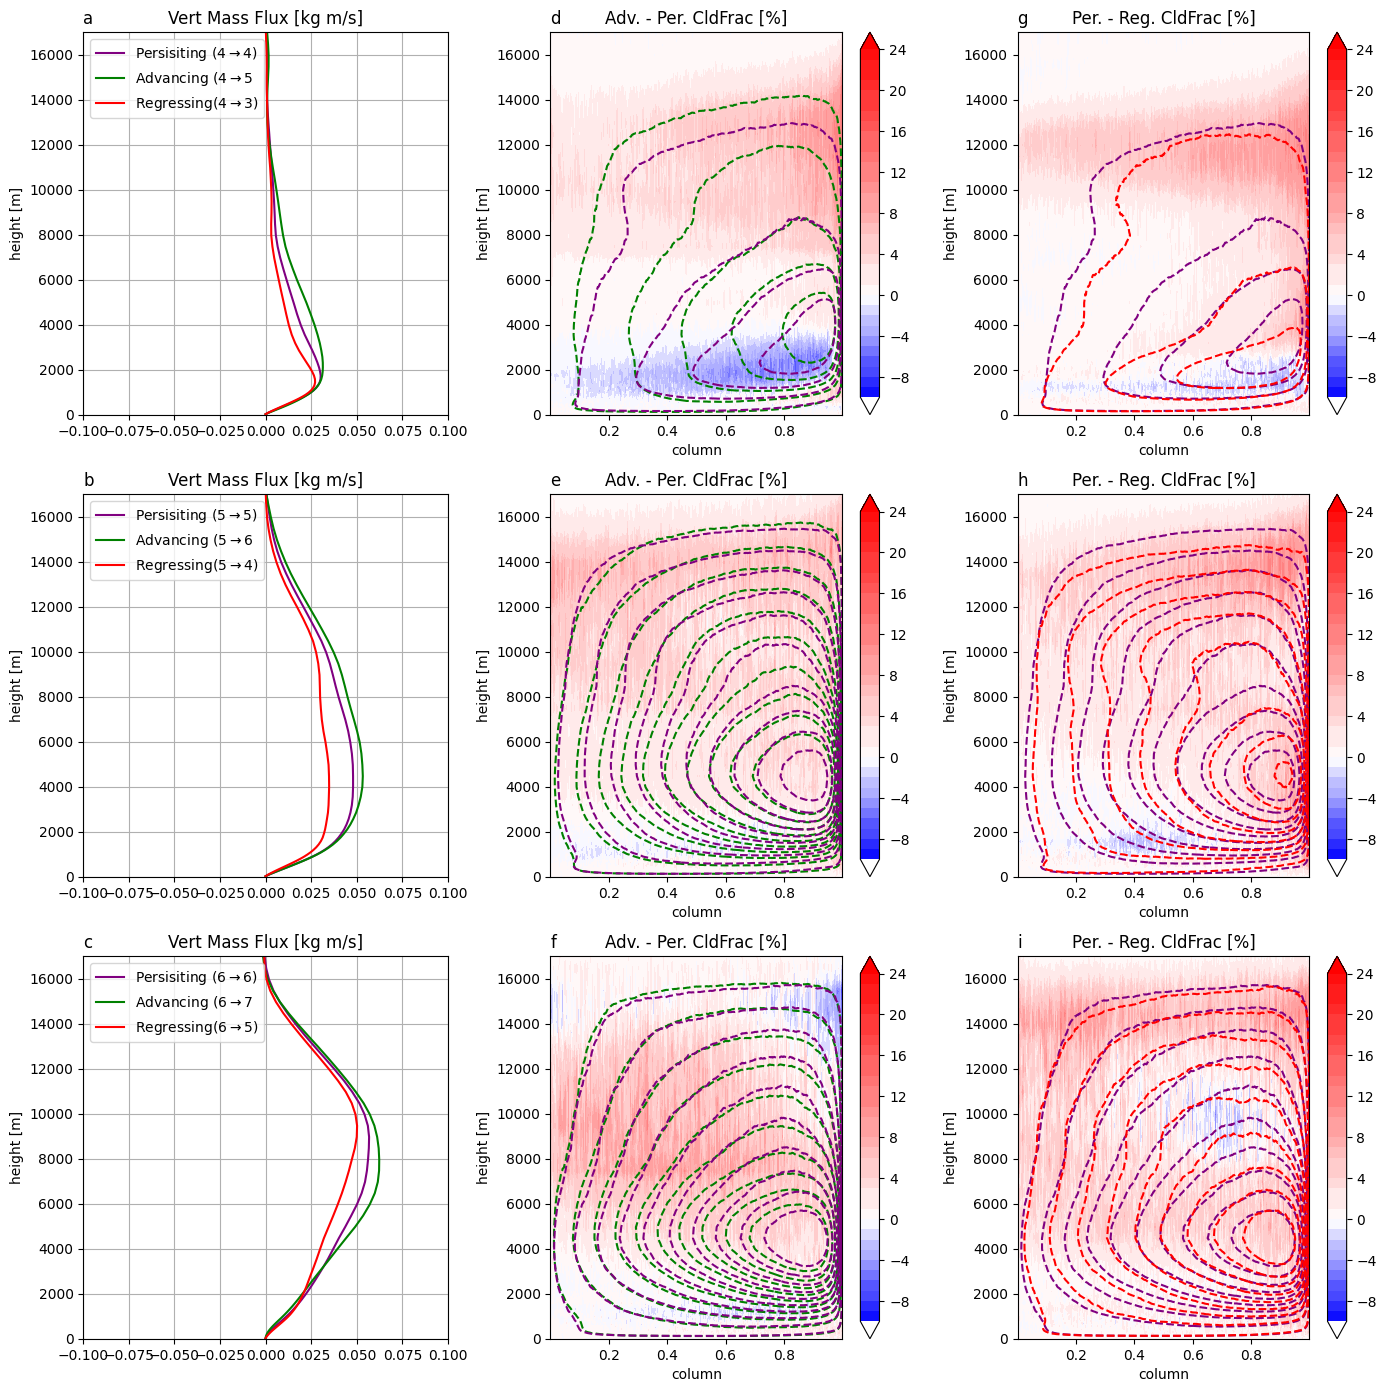

In [5]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(14, 14))
for i, p in enumerate([4,5,6]):
    persisting_circulation = load_composite_circulation('persisting', p).coarsen({'column': 5}).mean()
    persisting_cloudfrac = load_composite_cloudfraction('persisting', p).coarsen({'column': 5}).mean()
    persisting_mean_mass_flux = load_composite_mean_mass_flux('persisting', p).mean('scene')
    advancing_circulation = load_composite_circulation('advancing', p).coarsen({'column': 5}).mean()
    advancing_cloudfrac = load_composite_cloudfraction('advancing', p).coarsen({'column': 5}).mean()
    advancing_mean_mass_flux = load_composite_mean_mass_flux('advancing', p).mean('scene')
    regressing_circulation = load_composite_circulation('regressing', p).coarsen({'column': 5}).mean()
    regressing_cloudfrac = load_composite_cloudfraction('regressing', p).coarsen({'column': 5}).mean()
    regressing_mean_mass_flux = load_composite_mean_mass_flux('regressing', p).mean('scene')

    ax = axs[i, 0]
    persisting_mean_mass_flux.plot(ax=ax, y='z', label=fr'Persisiting $({p}\rightarrow {p}$)', color='purple')
    advancing_mean_mass_flux.plot(ax=ax, y='z', label=rf'Advancing $({p}\rightarrow {p+1}$', color='green')
    regressing_mean_mass_flux.plot(ax=ax, y='z', label=rf'Regressing$({p}\rightarrow {p-1}$)', color='red')
    ax.set_title(rf'Vert Mass Flux [kg m/s]')
    ax.set_title(chr(ord('a') + (i)), loc='left')
    ax.set_ylim(0, 17e3)
    ax.set_xlim(-0.1, 0.1)
    if True:
        ax.legend(loc='upper left')
    ax.grid()
    
    ax = axs[i, 1]
    levels = np.arange(-10, 25, 1)
    norm = colors.TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())
    cmap = plt.cm.bwr.copy()
    cmap.set_under('white')
    (advancing_circulation).plot.contour(ax=ax, levels = np.linspace(-150, 0, 20)[::2], colors='green')
    (persisting_circulation).plot.contour(ax=ax, levels = np.linspace(-150, 0, 20)[::2], colors='purple')
    (100*(advancing_cloudfrac-persisting_cloudfrac)).plot.contourf(ax=ax, levels=levels, cmap=cmap, norm=norm, extend='both')
    ax.set_title('Adv. - Per. CldFrac [%]')
    ax.set_title(chr(ord('d') + (i)), loc='left')
    ax.set_ylim(0, 17e3)

    ax = axs[i, 2]
    levels = np.arange(-10, 25, 1)
    norm = colors.TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())
    cmap = plt.cm.bwr.copy()
    cmap.set_under('white')
    (persisting_circulation).plot.contour(ax=ax, levels = np.linspace(-150, 0, 20)[::2], colors='purple')
    (regressing_circulation).plot.contour(ax=ax, levels = np.linspace(-150, 0, 20)[::2], colors='red')
    (100*(persisting_cloudfrac-regressing_cloudfrac)).plot.contourf(ax=ax, levels=levels, cmap=cmap, norm=norm, extend='both')
    ax.set_title('Per. - Reg. CldFrac [%]')
    ax.set_title(chr(ord('g') + (i)), loc='left')
    ax.set_ylim(0, 17e3)

fig.tight_layout(pad=1)
# save_figure(fig, 'different_evolutions_cloudfrac.pdf')

# Oneoff

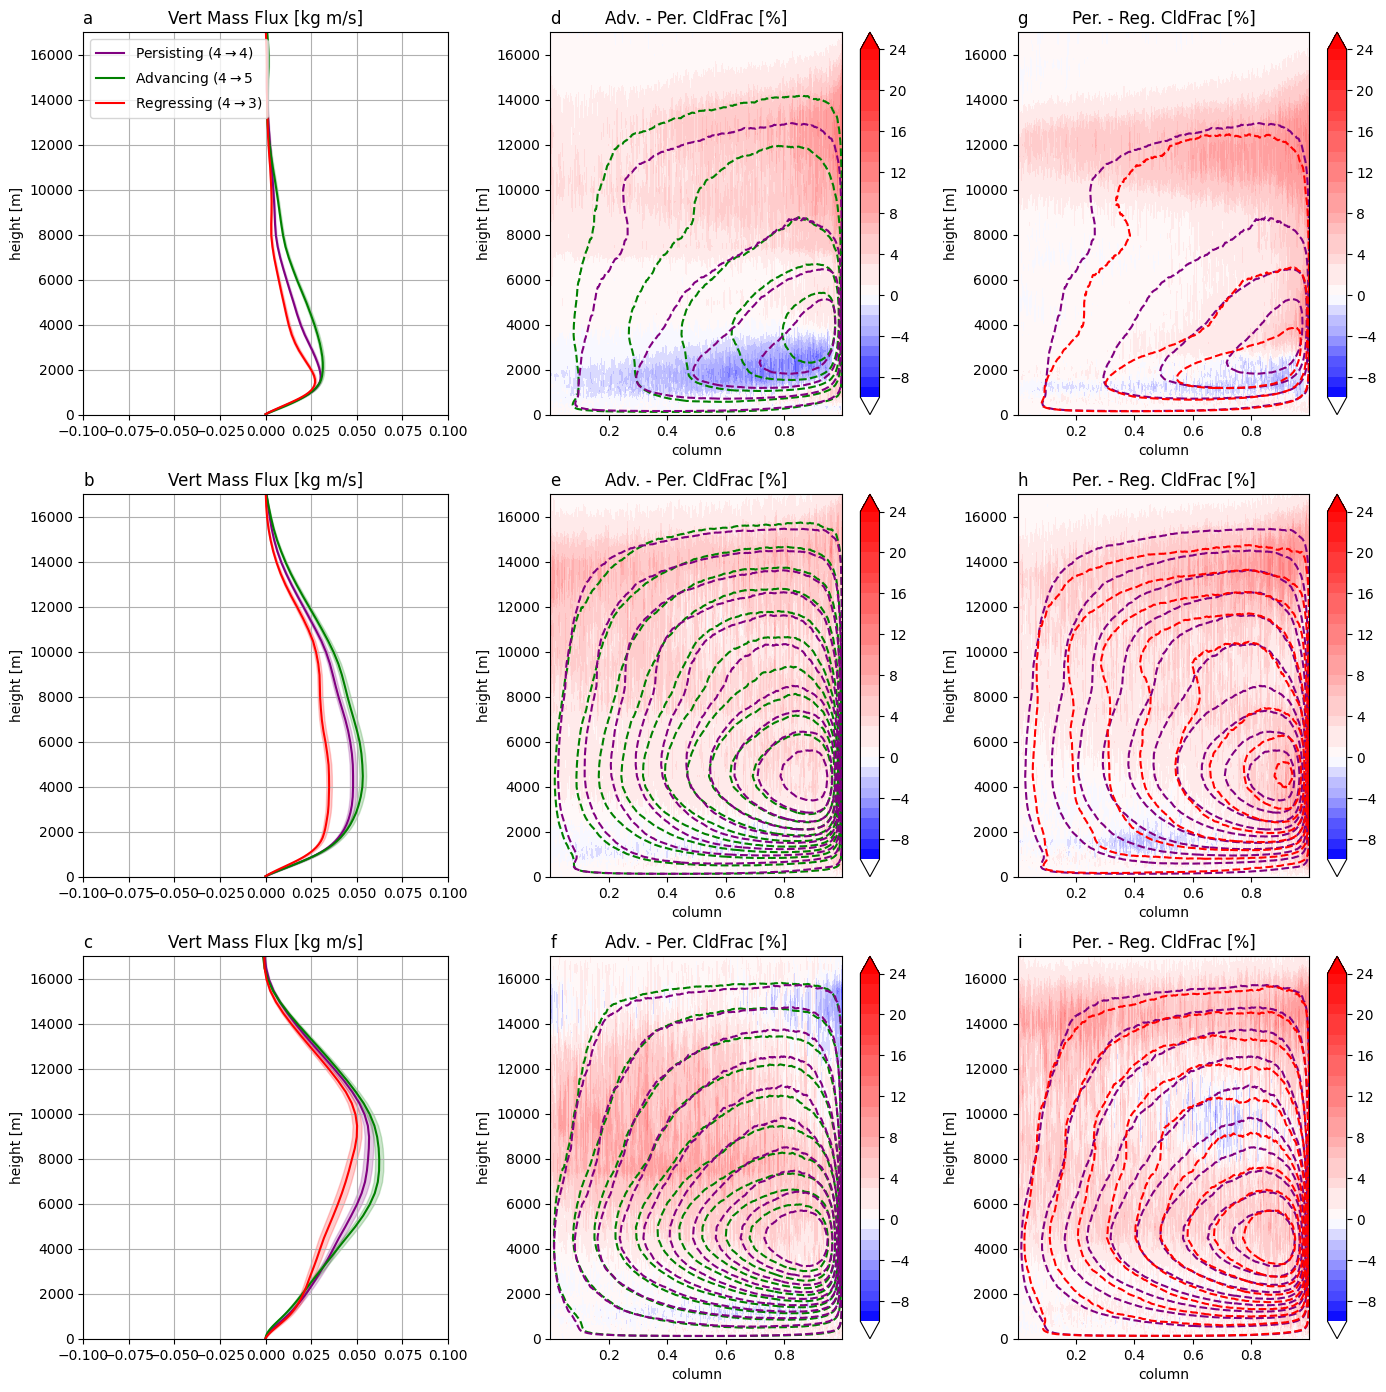

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(14, 14))

for i, p in enumerate([4, 5, 6]):
    persisting_data = load_composite_mean_mass_flux('persisting', p)
    persisting_mean_mass_flux = persisting_data.mean('scene')
    persisting_sem_mass_flux = persisting_data.std('scene') / np.sqrt(persisting_data.sizes['scene'])

    advancing_data = load_composite_mean_mass_flux('advancing', p)
    advancing_mean_mass_flux = advancing_data.mean('scene')
    advancing_sem_mass_flux = advancing_data.std('scene') / np.sqrt(advancing_data.sizes['scene'])

    regressing_data = load_composite_mean_mass_flux('regressing', p)
    regressing_mean_mass_flux = regressing_data.mean('scene')
    regressing_sem_mass_flux = regressing_data.std('scene') / np.sqrt(regressing_data.sizes['scene'])

    persisting_circulation = load_composite_circulation('persisting', p).coarsen({'column': 5}).mean()
    persisting_cloudfrac    = load_composite_cloudfraction('persisting', p).coarsen({'column': 5}).mean()

    advancing_circulation = load_composite_circulation('advancing', p).coarsen({'column': 5}).mean()
    advancing_cloudfrac    = load_composite_cloudfraction('advancing', p).coarsen({'column': 5}).mean()

    regressing_circulation = load_composite_circulation('regressing', p).coarsen({'column': 5}).mean()
    regressing_cloudfrac    = load_composite_cloudfraction('regressing', p).coarsen({'column': 5}).mean()

    ax = axs[i, 0]
    persisting_mean_mass_flux.plot(ax=ax, y='z', label=fr'Persisting $({p}\rightarrow {p}$)', color='purple')
    ax.fill_betweenx(
        persisting_mean_mass_flux.z,
        persisting_mean_mass_flux - persisting_sem_mass_flux,
        persisting_mean_mass_flux + persisting_sem_mass_flux,
        color='purple', alpha=0.2
    )
    advancing_mean_mass_flux.plot(ax=ax, y='z', label=rf'Advancing $({p}\rightarrow {p+1}$', color='green')
    ax.fill_betweenx(
        advancing_mean_mass_flux.z,
        advancing_mean_mass_flux - advancing_sem_mass_flux,
        advancing_mean_mass_flux + advancing_sem_mass_flux,
        color='green', alpha=0.2
    )
    regressing_mean_mass_flux.plot(ax=ax, y='z', label=rf'Regressing $({p}\rightarrow {p-1}$)', color='red')
    ax.fill_betweenx(
        regressing_mean_mass_flux.z,
        regressing_mean_mass_flux - regressing_sem_mass_flux,
        regressing_mean_mass_flux + regressing_sem_mass_flux,
        color='red', alpha=0.2
    )
    ax.set_title(rf'Vert Mass Flux [kg m/s]')
    ax.set_title(chr(ord('a') + i), loc='left')
    ax.set_ylim(0, 17e3)
    ax.set_xlim(-0.1, 0.1)
    if i == 0:
        ax.legend(loc='upper left')
    ax.grid()

    ax = axs[i, 1]
    levels = np.arange(-10, 25, 1)
    norm = colors.TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())
    cmap = plt.cm.bwr.copy()
    cmap.set_under('white')
    (advancing_circulation).plot.contour(ax=ax, levels=np.linspace(-150, 0, 20)[::2], colors='green')
    (persisting_circulation).plot.contour(ax=ax, levels=np.linspace(-150, 0, 20)[::2], colors='purple')
    (100*(advancing_cloudfrac - persisting_cloudfrac)).plot.contourf(
        ax=ax, levels=levels, cmap=cmap, norm=norm, extend='both'
    )
    ax.set_title('Adv. - Per. CldFrac [%]')
    ax.set_title(chr(ord('d') + i), loc='left')
    ax.set_ylim(0, 17e3)

    ax = axs[i, 2]
    (persisting_circulation).plot.contour(ax=ax, levels=np.linspace(-150, 0, 20)[::2], colors='purple')
    (regressing_circulation).plot.contour(ax=ax, levels=np.linspace(-150, 0, 20)[::2], colors='red')
    (100*(persisting_cloudfrac - regressing_cloudfrac)).plot.contourf(
        ax=ax, levels=levels, cmap=cmap, norm=norm, extend='both'
    )
    ax.set_title('Per. - Reg. CldFrac [%]')
    ax.set_title(chr(ord('g') + i), loc='left')
    ax.set_ylim(0, 17e3)

fig.tight_layout(pad=1)


# Real oneoff

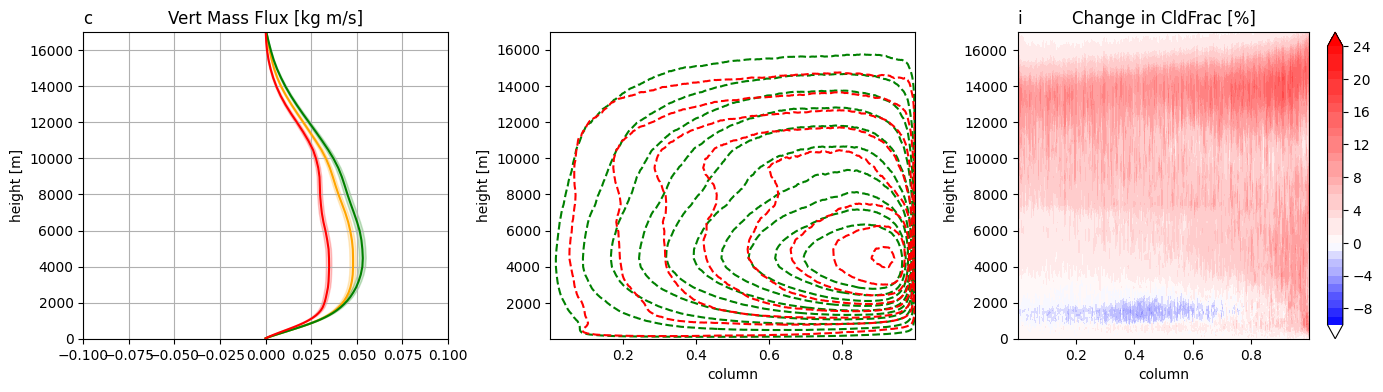

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(14, 4))

for p in [5]:
    persisting_data = load_composite_mean_mass_flux('persisting', p)
    persisting_mean_mass_flux = persisting_data.mean('scene')
    persisting_sem_mass_flux = persisting_data.std('scene') / np.sqrt(persisting_data.sizes['scene'])

    advancing_data = load_composite_mean_mass_flux('advancing', p)
    advancing_mean_mass_flux = advancing_data.mean('scene')
    advancing_sem_mass_flux = advancing_data.std('scene') / np.sqrt(advancing_data.sizes['scene'])

    regressing_data = load_composite_mean_mass_flux('regressing', p)
    regressing_mean_mass_flux = regressing_data.mean('scene')
    regressing_sem_mass_flux = regressing_data.std('scene') / np.sqrt(regressing_data.sizes['scene'])

    persisting_circulation = load_composite_circulation('persisting', p).coarsen({'column': 5}).mean()
    persisting_cloudfrac    = load_composite_cloudfraction('persisting', p).coarsen({'column': 5}).mean()

    advancing_circulation = load_composite_circulation('advancing', p).coarsen({'column': 5}).mean()
    advancing_cloudfrac    = load_composite_cloudfraction('advancing', p).coarsen({'column': 5}).mean()

    regressing_circulation = load_composite_circulation('regressing', p).coarsen({'column': 5}).mean()
    regressing_cloudfrac    = load_composite_cloudfraction('regressing', p).coarsen({'column': 5}).mean()

    ax = axs[0]
    persisting_mean_mass_flux.plot(ax=ax, y='z', label=fr'Persisting $({p}\rightarrow {p}$)', color='orange')
    ax.fill_betweenx(
        persisting_mean_mass_flux.z,
        persisting_mean_mass_flux - persisting_sem_mass_flux,
        persisting_mean_mass_flux + persisting_sem_mass_flux,
        color='orange', alpha=0.2
    )
    advancing_mean_mass_flux.plot(ax=ax, y='z', label=rf'Advancing $({p}\rightarrow {p+1}$', color='green')
    ax.fill_betweenx(
        advancing_mean_mass_flux.z,
        advancing_mean_mass_flux - advancing_sem_mass_flux,
        advancing_mean_mass_flux + advancing_sem_mass_flux,
        color='green', alpha=0.2
    )
    regressing_mean_mass_flux.plot(ax=ax, y='z', label=rf'Regressing $({p}\rightarrow {p-1}$)', color='red')
    ax.fill_betweenx(
        regressing_mean_mass_flux.z,
        regressing_mean_mass_flux - regressing_sem_mass_flux,
        regressing_mean_mass_flux + regressing_sem_mass_flux,
        color='red', alpha=0.2
    )
    ax.set_title(rf'Vert Mass Flux [kg m/s]')
    ax.set_title(chr(ord('a') + i), loc='left')
    ax.set_ylim(0, 17e3)
    ax.set_xlim(-0.1, 0.1)
    if i == 0:
        ax.legend(loc='upper left')
    ax.grid()

    ax = axs[1]
    levels = np.arange(-10, 25, 1)
    norm = colors.TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())
    cmap = plt.cm.bwr.copy()
    cmap.set_under('white')
    (advancing_circulation).plot.contour(ax=ax, levels=np.linspace(-150, 0, 20)[::2], colors='green')
    # (persisting_circulation).plot.contour(ax=ax, levels=np.linspace(-150, 0, 20)[::2], colors='orange')
    (regressing_circulation).plot.contour(ax=ax, levels=np.linspace(-150, 0, 20)[::2], colors='red')


    ax = axs[2]
    
    (100*(advancing_cloudfrac - regressing_cloudfrac)).plot.contourf(
        ax=ax, levels=levels, cmap=cmap, norm=norm, extend='both'
    )
    ax.set_title('Change in CldFrac [%]')
    ax.set_title(chr(ord('g') + i), loc='left')
    ax.set_ylim(0, 17e3)

fig.tight_layout(pad=1)
